## 📌 Tujuan Proyek
Proyek ini bertujuan untuk membangun model regresi guna memprediksi harga jual mobil berdasarkan berbagai fitur seperti jarak tempuh (km driven), jenis bahan bakar, merek mobil, dan lainnya. Model ini dapat membantu konsumen atau dealer mobil dalam menentukan harga pasar yang wajar.

## Import Library

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mstats
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.stats.mstats import winsorize
%matplotlib inline

## Import Library

Pada tahap ini, kita mengimpor beberapa library penting untuk proyek ini:

- `pandas` dan `numpy` digunakan untuk manipulasi dan analisis data numerik serta struktur data tabular.
- `matplotlib.pyplot` dan `seaborn` digunakan untuk visualisasi data. Keduanya sangat berguna dalam eksplorasi data awal, khususnya untuk melihat distribusi dan mendeteksi outlier.
- `%matplotlib inline` adalah magic command pada Jupyter Notebook untuk memastikan grafik tampil langsung di dalam notebook.

Penggunaan library ini memungkinkan analisis data dilakukan secara efisien dan visualisasi dilakukan secara informatif, yang sangat penting untuk mendeteksi pola dan anomali sebelum membangun model.

## Load Dataset

In [2]:
# Load dataset
url = 'https://raw.githubusercontent.com/go0se05/predictive-analytics/refs/heads/main/Cars%20dataset.csv'
cars = pd.read_csv(url)
cars

,brand,km_driven,fuel,owner,selling_price
0,Maruti,145500,Diesel,First Owner,450000
1,Skoda,120000,Diesel,Second Owner,370000
2,Honda,140000,Petrol,Third Owner,158000
3,Hyundai,127000,Diesel,First Owner,225000
4,Maruti,120000,Petrol,First Owner,130000
...,...,...,...,...,...
8123,Hyundai,110000,Petrol,First Owner,320000
8124,Hyundai,119000,Diesel,Fourth & Above Owner,135000
8125,Maruti,120000,Diesel,First Owner,382000
8126,Tata,25000,Diesel,First Owner,290000


## Memuat Dataset

Dataset dimuat dari sumber eksternal berupa URL GitHub menggunakan fungsi `pd.read_csv()`. Dataset ini berisi informasi mengenai mobil bekas, termasuk fitur-fitur seperti:

- Brand mobil (`brand`)
- Kilometer yang sudah ditempuh (`km_driven`)
- Jenis bahan bakar (`fuel`)
- Kepemilikan mobil (`owner`)
- Harga (`selling_price`)

Tujuan dari memuat data ini adalah sebagai langkah awal untuk memahami struktur data dan memulai tahap eksplorasi serta pembersihan. Proses ini memastikan bahwa data berhasil diperoleh secara utuh sebelum dilakukan pemrosesan lebih lanjut.

In [3]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   brand          8128 non-null   object
 1   km_driven      8128 non-null   int64 
 2   fuel           8128 non-null   object
 3   owner          8128 non-null   object
 4   selling_price  8128 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 317.6+ KB


### 1. Struktur Data (`cars.info()`)

- Dataset terdiri dari **8128 baris dan 5 kolom**.
- Tiga kolom bertipe **object (kategori)**: `brand`, `fuel`, dan `owner`.
- Dua kolom bertipe **numerik** (`int64`): `km_driven` dan `selling_price`.
- Tidak ditemukan **missing values**, yang merupakan hal positif karena tidak perlu melakukan imputasi data atau penghapusan baris/kolom.

 **Insight**:
- Karena kolom `brand`, `fuel`, dan `owner` bertipe kategori, perlu dilakukan encoding (seperti One-Hot atau Label Encoding) sebelum digunakan dalam model prediktif.
- Kolom numerik bisa langsung dianalisis lebih lanjut, termasuk eksplorasi distribusi dan deteksi outlier.

---

In [4]:
cars.describe()

,km_driven,selling_price
count,8.128000e+03,8.128000e+03
mean,6.981951e+04,6.382718e+05
std,5.655055e+04,8.062534e+05
min,1.000000e+00,2.999900e+04
25%,3.500000e+04,2.549990e+05
50%,6.000000e+04,4.500000e+05
75%,9.800000e+04,6.750000e+05
max,2.360457e+06,1.000000e+07


### 2. Statistik Deskriptif (`cars.describe()`)

#### ➤ `km_driven` (Jarak tempuh kendaraan)
- **Rata-rata (mean)**: ~69.891 km
- **Median (50%)**: 60.000 km
- **Standar deviasi**: ~55.650 km → menunjukkan sebaran cukup besar
- **Nilai maksimum**: 2.364.057 km → sangat tinggi dan **berpotensi sebagai outlier ekstrem**
- **Nilai minimum**: 1.000 km → logis untuk kendaraan bekas

 **Insight**:
- Nilai maksimum yang jauh lebih tinggi dari Q3 (90.000 km) menunjukkan adanya **right-skewed distribution** dan kemungkinan **outlier signifikan**.
- Model regresi sensitif terhadap outlier, sehingga penting untuk melakukan Winsorization atau transformasi.

#### ➤ `selling_price` (Harga jual kendaraan)
- **Rata-rata**: ~638.000
- **Median (50%)**: 450.000
- **Maksimum**: 10.000.000 → kemungkinan mobil mewah (luxury cars)
- **Minimum**: 29.999 → kendaraan bekas yang sangat murah

 **Insight**:
- Selisih besar antara **mean dan median** menunjukkan data **positively skewed (condong ke kanan)**.
- Nilai maksimum 10 juta kemungkinan outlier. Harga ini bisa valid, tapi tetap perlu dicek karena bisa mendistorsi model.
- Skewness seperti ini bisa menyebabkan model memprediksi terlalu tinggi, sehingga scaling dan penanganan outlier sangat disarankan.

---

## Handling Missing Values dan Outlier

In [5]:
# Cek missing values
print(cars.isnull().sum())
print()

brand            0
km_driven        0
fuel             0
owner            0
selling_price    0
dtype: int64



In [6]:
# Drop baris dengan nilai kosong (jika ada)
cars.dropna(inplace=True)

In [7]:
# Pisahkan fitur numerik dan kategorikal
num_cols = cars.select_dtypes(include='number').columns.tolist()
cat_cols = cars.select_dtypes(include='object').columns.tolist()

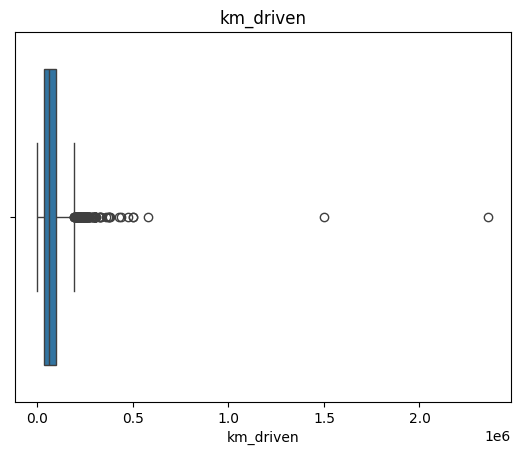

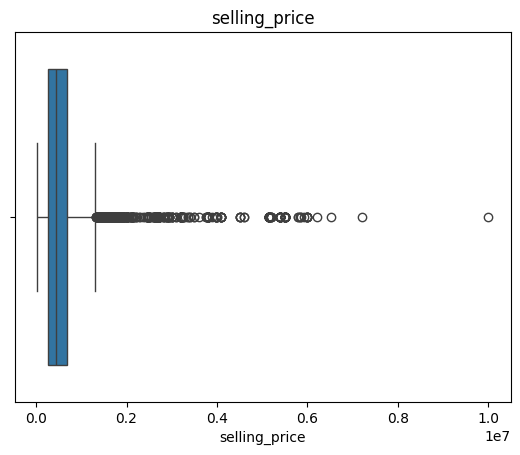

In [8]:
# Cek outlier secara visual
for col in num_cols:
    sns.boxplot(x=cars[col])
    plt.title(col)
    plt.show()

## Analisis Outlier 

### Distribusi Outlier
#### `km_driven` (Jarak Tempuh)
- **Jumlah outlier**: 166
- **Rentang nilai outlier**: 0 - 2.0 juta km
- **Interpretasi**:
  - Mobil dengan jarak tempuh > 1.5 juta km termasuk sangat ekstrim
  - Kemungkinan penyebab:
    - Mobil tua yang masih digunakan (contoh: taksi/truk)
    - Kesalahan input data (misal: 150,000 km → 1,500,000 km)

#### `selling_price` (Harga Jual)
- **Jumlah outlier**: 167  
- **Rentang nilai outlier**: ₹0 - ₹10 juta
- **Interpretasi**:
  - Harga ≈₹0 mungkin:
    - Giveaway/iklan promo
    - Kesalahan input
  - Harga >₹8 juta biasanya:
    - Mobil mewah bekas (BMW, Mercedes)
    - Mobil klasik langka
---

In [9]:
# Salin dataset agar tidak mengubah yang asli
cars_winsorized = cars.copy()

for col in num_cols:
    Q1 = cars[col].quantile(0.25)
    Q3 = cars[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Winsorization: ganti nilai outlier dengan batas IQR
    cars_winsorized[col] = np.where(
        cars[col] < lower_bound, lower_bound,
        np.where(cars[col] > upper_bound, upper_bound, cars[col])
    )

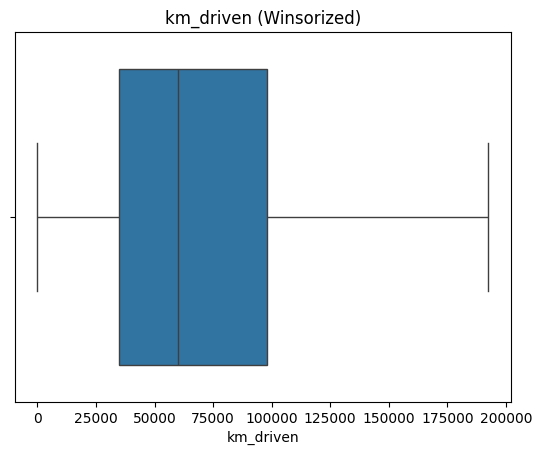

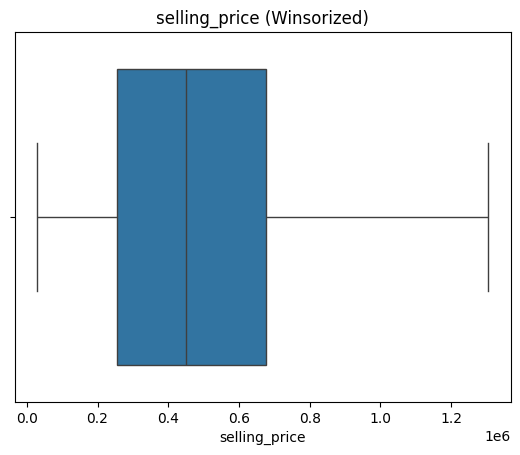

In [10]:
for col in num_cols:
    sns.boxplot(x=cars_winsorized[col])
    plt.title(f"{col} (Winsorized)")
    plt.show()


## Penanganan Outlier dengan Winsorization

Setelah outlier teridentifikasi, kita melakukan **Winsorization** sebagai teknik penanganannya. Berbeda dengan metode trimming (menghapus data), Winsorization mengganti outlier dengan nilai ambang batas tertentu.

Metode yang digunakan berbasis **Interquartile Range (IQR)**:
- **Q1 (Kuartil 1)**: Nilai pada persentil ke-25
- **Q3 (Kuartil 3)**: Nilai pada persentil ke-75
- **IQR = Q3 - Q1**

Batas bawah dan atas ditentukan dengan rumus:
- Lower Bound = Q1 - 1.5 * IQR
- Upper Bound = Q3 + 1.5 * IQR

Setiap nilai yang lebih rendah dari batas bawah akan diubah menjadi nilai batas bawah, begitu juga dengan yang lebih tinggi dari batas atas.

### Tujuan:
- Mengurangi pengaruh outlier ekstrem tanpa mengorbankan jumlah data.
- Menjaga integritas data agar tetap representatif.
- Meningkatkan performa dan stabilitas model regresi di tahap selanjutnya.

Metode ini sangat cocok jika data memiliki outlier tapi kita tidak ingin kehilangan informasi sebanyak saat menggunakan metode penghapusan (drop).

In [11]:
cars_winsorized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   brand          8128 non-null   object 
 1   km_driven      8128 non-null   float64
 2   fuel           8128 non-null   object 
 3   owner          8128 non-null   object 
 4   selling_price  8128 non-null   float64
dtypes: float64(2), object(3)
memory usage: 317.6+ KB


In [12]:
cars_winsorized.describe()

,km_driven,selling_price
count,8128.000000,8.128000e+03
mean,68311.382013,5.155124e+05
std,43569.154403,3.337026e+05
min,1.000000,2.999900e+04
25%,35000.000000,2.549990e+05
50%,60000.000000,4.500000e+05
75%,98000.000000,6.750000e+05
max,192500.000000,1.305002e+06


<Axes: xlabel='brand', ylabel='selling_price'>

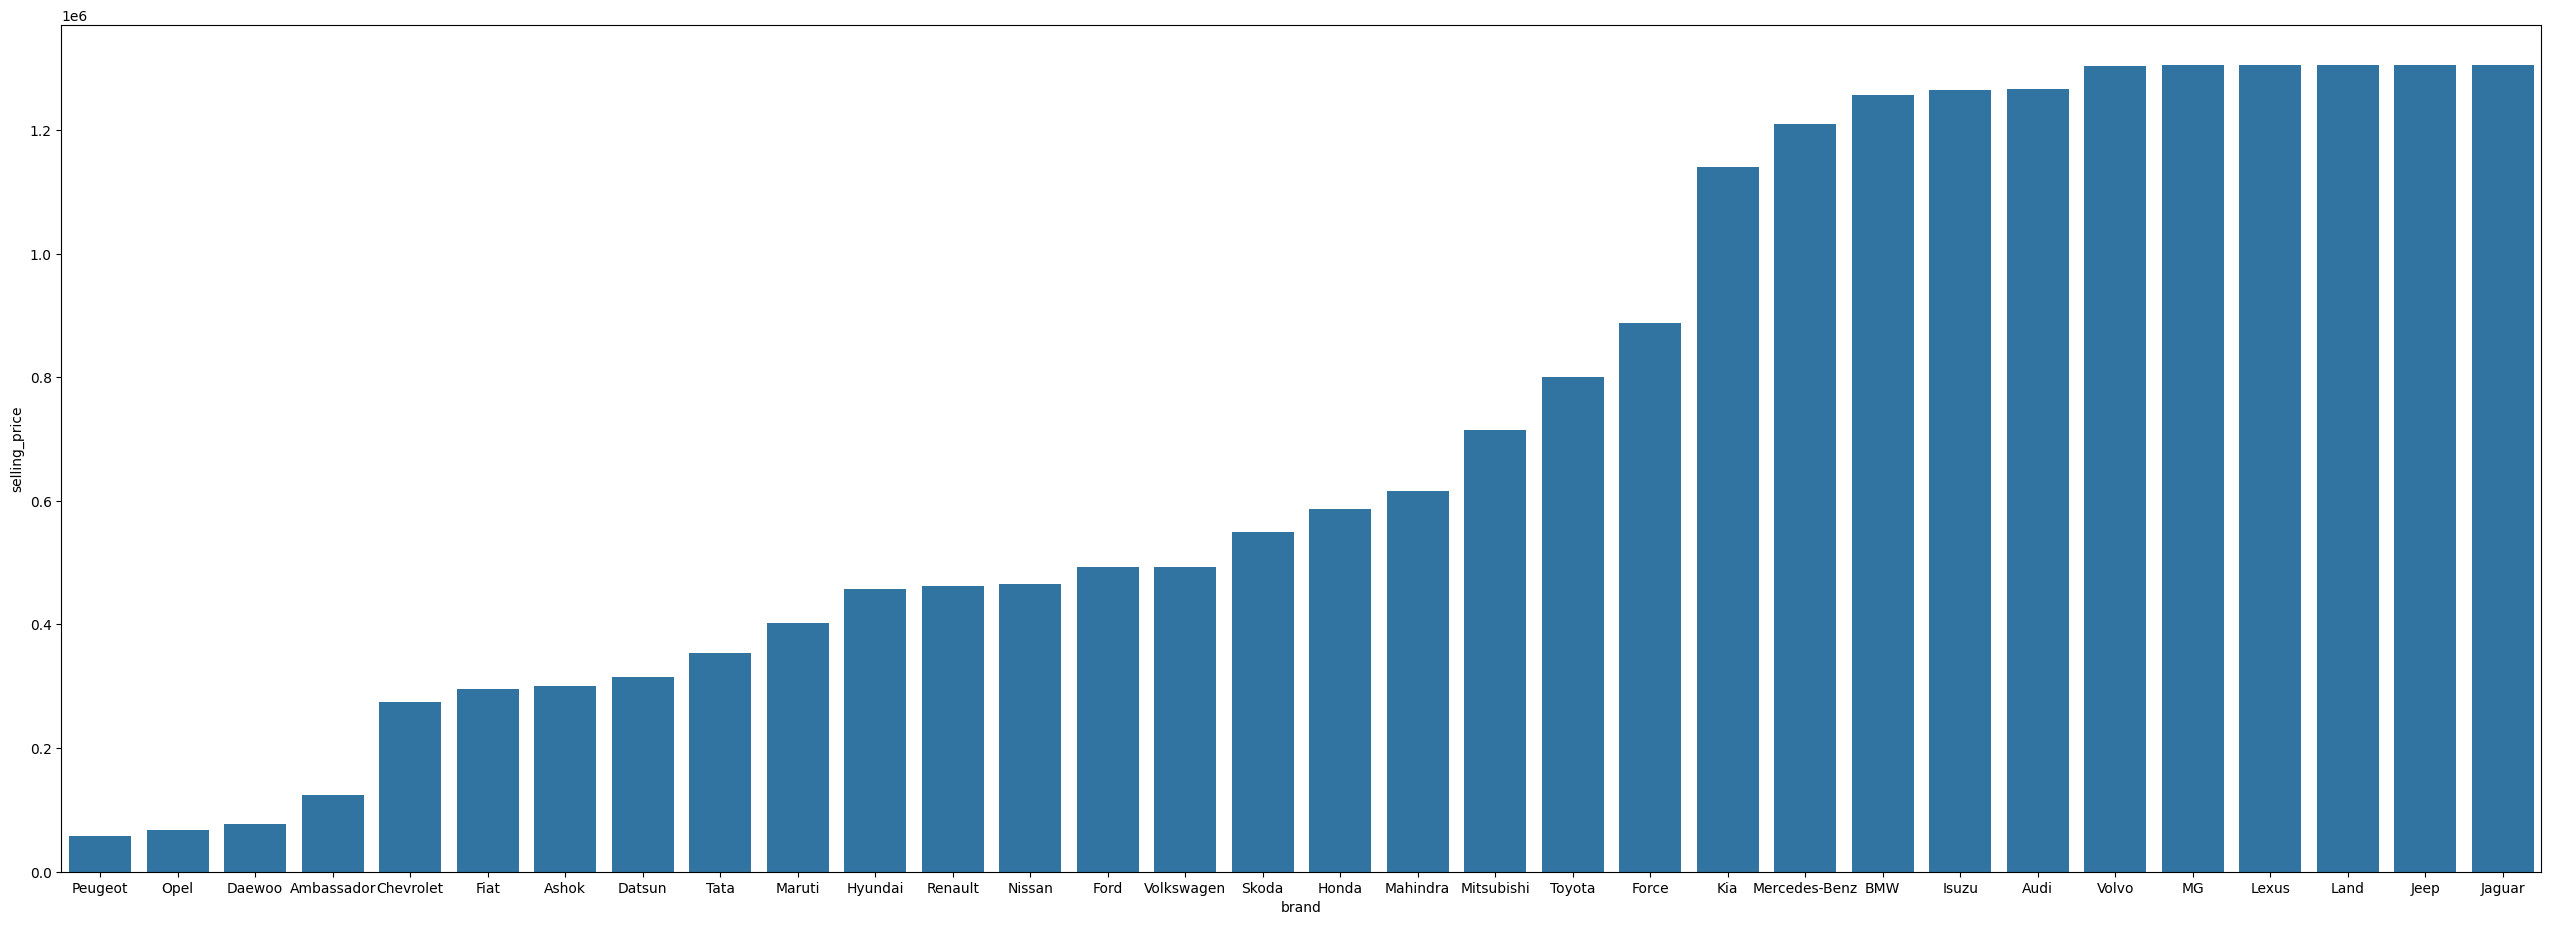

In [13]:
df=cars_winsorized.groupby('brand').agg({"selling_price":"mean"}).reset_index().sort_values(by='selling_price')
plt.figure(figsize=(32,11))

sns.barplot(x='brand',y='selling_price',data=df)

Kode ini digunakan untuk menganalisis **rata-rata harga jual mobil bekas** berdasarkan jumlah pemilik sebelumnya (_owner_), setelah dilakukan winsorization (penanganan outlier).

Berdasarkan hasil visualisasi, berikut adalah beberapa insight yang bisa didapatkan:

* **Distribusi Harga Jual Berdasarkan Merek:** Gambar ini menampilkan bar chart yang menunjukkan harga jual ('selling_price') untuk berbagai merek mobil ('brand'). Sumbu X adalah merek dan sumbu Y adalah harga jual.

* **Merek dengan Harga Jual Terendah:** Merek-merek seperti Peugeot, Opel, Daewoo, Ambassador, dan Chevrolet memiliki harga jual yang relatif rendah dibandingkan merek lainnya.

* **Merek dengan Harga Jual Tertinggi:** Merek-merek seperti Land Rover, Lexus, Jeep, dan Jaguar memiliki harga jual yang paling tinggi.

* **Tren Peningkatan Harga Jual:** Terlihat jelas ada tren peningkatan harga jual dari kiri ke kanan. Merek-merek di sisi kiri memiliki harga jual yang lebih rendah, sementara merek-merek di sisi kanan memiliki harga jual yang lebih tinggi.

* **Perbandingan Harga Jual Antar Merek:** Kita bisa membandingkan secara langsung harga jual antara dua merek tertentu. Misalnya, harga jual Maruti lebih tinggi dari Hyundai, dan harga jual Mercedes-Benz lebih tinggi dari Kia.

* **Potensi Segmentasi Pasar:** Data ini bisa mengindikasikan segmen pasar yang berbeda. Merek-merek dengan harga rendah mungkin menargetkan segmen pasar yang sensitif terhadap harga, sementara merek-merek dengan harga tinggi menargetkan segmen premium.

* **Visualisasi yang Jelas:** Bar chart ini memberikan visualisasi yang jelas dan mudah dipahami tentang hubungan antara merek dan harga jual.

In [14]:
models=df.brand.tolist()

<Axes: xlabel='fuel', ylabel='selling_price'>

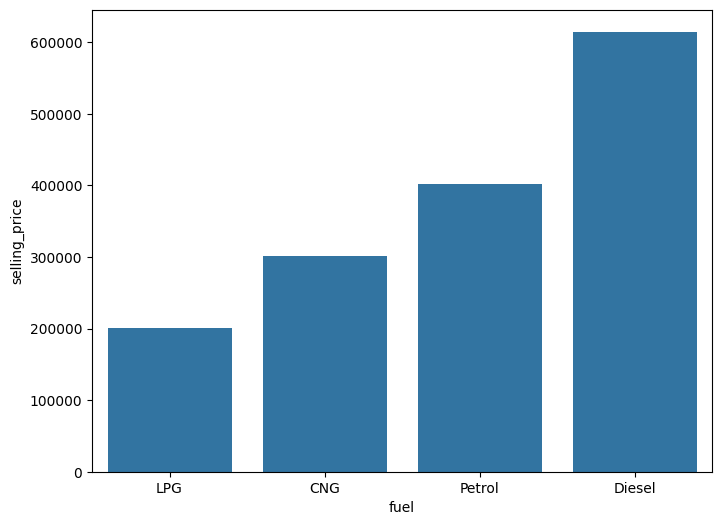

In [15]:
df=cars_winsorized.groupby('fuel').agg({"selling_price":"mean"}).reset_index().sort_values(by='selling_price')
plt.figure(figsize=(8,6))

sns.barplot(x='fuel',y='selling_price',data=df)

Kode ini bertujuan untuk:
1. Menganalisis **rata-rata harga jual mobil** berdasarkan jenis bahan bakar
2. Memvisualisasikan perbandingan harga antar tipe bahan bakar
3. Mengidentifikasi pola harga di pasar mobil bekas

Berdasarkan gambar bar plot yang diberikan, berikut adalah beberapa insight yang bisa didapatkan:

* **Perbandingan Rata-rata Harga Jual Berdasarkan Jenis Bahan Bakar:** Bar plot ini memvisualisasikan rata-rata harga jual ('selling_price') untuk mobil berdasarkan jenis bahan bakarnya ('fuel').

* **Urutan Harga Jual dari Terendah ke Tertinggi:**
    * **LPG** memiliki rata-rata harga jual terendah, sekitar 200.000.
    * **CNG** berada di atas LPG, dengan rata-rata harga jual sekitar 300.000.
    * **Petrol (Bensin)** memiliki rata-rata harga jual yang lebih tinggi lagi, mendekati 400.000.
    * **Diesel (Solar)** memiliki rata-rata harga jual tertinggi, melebihi 600.000.

* **Mobil Diesel Cenderung Paling Mahal:** Dari grafik, terlihat jelas bahwa mobil yang menggunakan bahan bakar Diesel memiliki rata-rata harga jual yang jauh lebih tinggi dibandingkan dengan jenis bahan bakar lainnya.

* **Mobil Bensin dan CNG di Tengah:** Mobil bensin dan CNG berada di segmen harga menengah, dengan bensin sedikit lebih mahal dari CNG.

* **Mobil LPG adalah yang Paling Terjangkau:** Jika pertimbangan harga jual adalah faktor utama, mobil dengan bahan bakar LPG merupakan pilihan yang paling ekonomis.

* **Implikasi Pasar:** Perbedaan harga jual ini bisa mencerminkan berbagai faktor, seperti biaya produksi, fitur standar, segmen pasar yang dituju, atau bahkan kebijakan pajak terkait jenis bahan bakar.

* **Potensi Keputusan Pembelian Konsumen:** Konsumen yang memprioritaskan harga jual yang lebih rendah mungkin akan cenderung memilih mobil berbahan bakar LPG atau CNG. Sebaliknya, konsumen yang mencari performa atau fitur tertentu yang umumnya terkait dengan mobil diesel mungkin bersedia membayar lebih.

<Axes: xlabel='owner', ylabel='selling_price'>

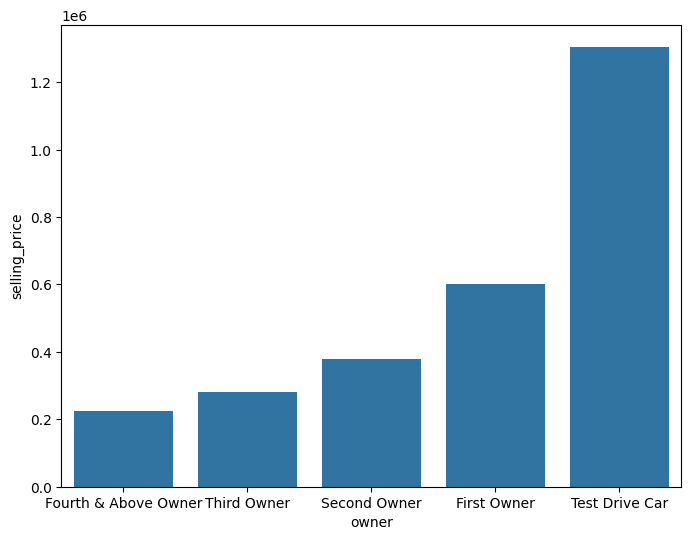

In [16]:
df=cars_winsorized.groupby('owner').agg({"selling_price":"mean"}).reset_index().sort_values(by='selling_price')
plt.figure(figsize=(8,6))

sns.barplot(x='owner',y='selling_price',data=df)

Kode ini digunakan untuk:
1. Menganalisis hubungan antara **jumlah pemilik sebelumnya** dengan **harga jual mobil bekas**
2. Memvisualisasikan perbedaan harga rata-rata berdasarkan sejarah kepemilikan
3. Mengidentifikasi pola penurunan harga seiring bertambahnya pemilik

Berdasarkan gambar bar plot yang diberikan, berikut adalah beberapa insight yang bisa didapatkan:

* **Perbandingan Rata-rata Harga Jual Berdasarkan Status Kepemilikan (Owner):** Plot ini menunjukkan rata-rata harga jual ('selling_price') mobil berdasarkan kategori 'owner' (kepemilikan sebelumnya).

* **Urutan Harga Jual dari Terendah ke Tertinggi Berdasarkan Riwayat Kepemilikan:**
    * **"Fourth & Above Owner"** (pemilik keempat ke atas) memiliki rata-rata harga jual terendah, yaitu sedikit di atas 200.000.
    * **"Third Owner"** (pemilik ketiga) memiliki rata-rata harga jual yang sedikit lebih tinggi dari pemilik keempat ke atas, sekitar 280.000.
    * **"Second Owner"** (pemilik kedua) memiliki rata-rata harga jual yang lebih tinggi lagi, mendekati 400.000.
    * **"First Owner"** (pemilik pertama) memiliki rata-rata harga jual yang jauh lebih tinggi, sekitar 600.000.
    * **"Test Drive Car"** (mobil bekas test drive) memiliki rata-rata harga jual yang paling tinggi, mencapai sekitar 1.250.000.

* **Nilai Depresiasi Terlihat Jelas:** Semakin banyak jumlah pemilik sebelumnya, semakin rendah rata-rata harga jual mobil. Ini adalah gambaran jelas dari depresiasi nilai mobil seiring bertambahnya kepemilikan.

* **Mobil Bekas Test Drive Paling Mahal:** Ini adalah insight yang menarik dan sedikit kontraintuitif bagi sebagian orang. Mobil yang pernah digunakan untuk *test drive* memiliki rata-rata harga jual tertinggi. Hal ini bisa jadi karena:
    * Mobil test drive umumnya adalah model-model terbaru atau spesifikasi tinggi.
    * Meskipun sudah digunakan, mereka seringkali terawat dengan sangat baik dan mungkin memiliki kilometer rendah (dibandingkan mobil bekas umum) atau dijual dengan garansi khusus.
    * Kemungkinan dijual langsung oleh dealer dengan harga yang relatif tinggi karena masih dianggap "baru" dalam kondisi tertentu.

* **Mobil "First Owner" Menjaga Nilai Cukup Baik:** Mobil yang dijual oleh pemilik pertamanya ('First Owner') masih memiliki harga jual yang signifikan, jauh lebih tinggi dibandingkan mobil yang sudah berpindah tangan beberapa kali. Ini menunjukkan bahwa status "first owner" memberikan nilai tambah bagi pembeli.

* **Implikasi bagi Pembeli dan Penjual:**
    * **Bagi Pembeli:** Jika mencari mobil dengan harga paling terjangkau, pilihan terbaik adalah mobil dengan riwayat kepemilikan yang sudah banyak. Jika mencari mobil yang relatif baru dengan harga lebih baik dari "mobil baru", "first owner" bisa menjadi pilihan.
    * **Bagi Penjual:** Semakin sedikit jumlah pemilik sebelumnya, semakin tinggi harga yang bisa diharapkan. Menjual mobil sebagai "first owner" memberikan keuntungan harga yang signifikan.

Secara keseluruhan, grafik ini memberikan pemahaman yang kuat tentang bagaimana riwayat kepemilikan mobil memengaruhi harga jualnya di pasar.

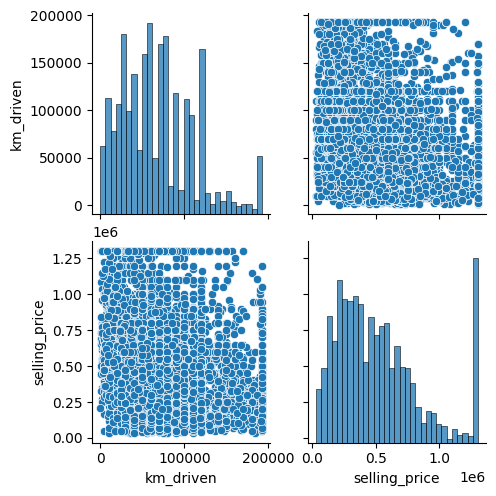

In [17]:
sns.pairplot(cars_winsorized[['km_driven','selling_price']])

Kode ini digunakan untuk:
1. Mengeksplorasi hubungan **non-linear** antara `km_driven` (jarak tempuh) dan `selling_price` (harga jual)
2. Memvisualisasikan distribusi masing-masing variabel
3. Mengidentifikasi pola/korelasi antara dua variabel numerik

Berdasarkan gambar PairPlot yang ditampilkan, berikut adalah beberapa insight yang bisa didapatkan mengenai hubungan antara `km_driven` (jarak tempuh) dan `selling_price` (harga jual):

* **1. Distribusi `km_driven` (Histogram di Kiri Atas):**
    * Sebagian besar mobil memiliki `km_driven` di bawah 50.000 km.
    * Terdapat penurunan frekuensi yang signifikan seiring bertambahnya `km_driven`.
    * Ada beberapa mobil dengan `km_driven` sangat tinggi, bahkan mendekati 200.000 km, meskipun jumlahnya sedikit.
    * Distribusi ini menunjukkan bahwa sebagian besar data adalah mobil dengan jarak tempuh rendah hingga menengah.

* **2. Distribusi `selling_price` (Histogram di Kanan Bawah):**
    * Mayoritas mobil memiliki `selling_price` di bawah 500.000 (kemungkinan dalam satuan mata uang tertentu, misal Rupiah).
    * Distribusi cenderung miring ke kanan (positively skewed), menunjukkan bahwa ada lebih banyak mobil dengan harga jual rendah dan semakin sedikit mobil dengan harga jual sangat tinggi.
    * Ada juga sejumlah kecil mobil dengan harga jual yang sangat tinggi, bahkan melebihi 1.000.000.

* **3. Hubungan antara `km_driven` dan `selling_price` (Scatter Plot di Kiri Bawah):**
    * **Korelasi Negatif:** Terlihat adanya pola umum bahwa seiring dengan peningkatan `km_driven`, `selling_price` cenderung menurun. Ini adalah hubungan korelasi negatif yang diharapkan.
    * **Penyebaran Data:** Meskipun ada tren korelasi negatif, penyebaran data cukup lebar, terutama pada `km_driven` rendah. Ini berarti untuk `km_driven` yang sama, bisa ada rentang `selling_price` yang bervariasi. Faktor-faktor lain (seperti merek, model, tahun, kondisi, dll.) jelas berperan besar dalam menentukan harga jual.
    * **Titik Data Padat di Area Rendah:** Konsentrasi titik data yang paling padat berada pada area `km_driven` rendah dan `selling_price` rendah hingga menengah, sejalan dengan distribusi masing-masing variabel.
    * **Outlier/Pengecualian:** Ada beberapa titik data yang mungkin dianggap outlier, misalnya mobil dengan `km_driven` tinggi namun harga jualnya masih relatif tinggi, atau sebaliknya.

* **4. Scatter Plot `selling_price` vs `km_driven` (Kanan Atas):**
    * Plot ini adalah cerminan dari scatter plot di kiri bawah, hanya saja sumbu X dan Y-nya terbalik. Interpretasinya sama: `selling_price` di sumbu Y dan `km_driven` di sumbu X. Ini juga menunjukkan korelasi negatif.

#### Visualisasi korelasi hitmap

<Axes: >

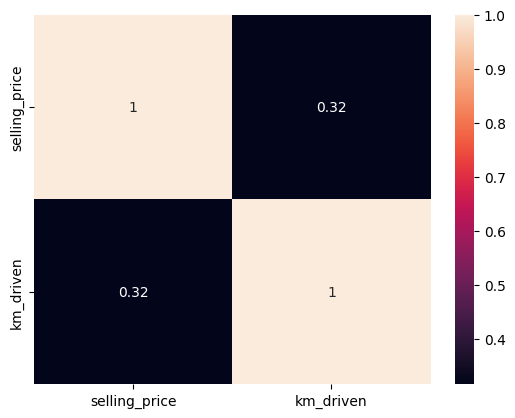

In [18]:
sns.heatmap(cars_winsorized[['selling_price','km_driven']].corr().abs(),annot=True)

Kode ini digunakan untuk:
1. Mengukur **tingkat hubungan linear** antara `selling_price` (harga jual) dan `km_driven` (jarak tempuh)
2. Memvisualisasikan matriks korelasi dalam bentuk heatmap
3. Mengidentifikasi kekuatan hubungan antar variabel numerik

Berdasarkan gambar heatmap yang ditampilkan, berikut adalah beberapa insight yang bisa didapatkan:

* **Matriks Korelasi (Absolute Value):** Heatmap ini menampilkan matriks korelasi antara dua variabel: 'selling_price' dan 'km_driven'. Penggunaan `.abs()` pada kode menunjukkan bahwa nilai yang ditampilkan adalah nilai absolut dari koefisien korelasi. Artinya, kita melihat kekuatan hubungan tanpa mempertimbangkan arahnya (positif atau negatif).

* **Korelasi Sempurna dengan Diri Sendiri:**
    * Diagonal matriks (sel 'selling_price' vs 'selling_price' dan 'km_driven' vs 'km_driven') menunjukkan nilai **1**. Ini karena variabel selalu berkorelasi sempurna dengan dirinya sendiri.

* **Korelasi Antar Variabel ('selling_price' dan 'km_driven'):**
    * Nilai korelasi absolut antara 'selling_price' dan 'km_driven' adalah **0.32**.
    * **Interpretasi Korelasi 0.32 (Absolut):**
        * Karena ini adalah nilai absolut, kita tahu bahwa ada hubungan antara kedua variabel ini.
        * Nilai 0.32 menunjukkan korelasi yang **lemah hingga moderat**.
        * Meskipun heatmap menampilkan nilai absolut, dari pengalaman umum tentang data mobil, kita bisa menduga bahwa korelasi aslinya adalah **negatif**. Artinya, seiring dengan bertambahnya jarak tempuh (`km_driven`), harga jual (`selling_price`) cenderung menurun. Nilai absolut 0.32 menunjukkan bahwa hubungan negatif ini tidak terlalu kuat, yang berarti ada banyak faktor lain selain jarak tempuh yang memengaruhi harga jual mobil.

* **Visualisasi Kekuatan Korelasi:**
    * Warna gelap pada heatmap menunjukkan korelasi yang lebih kuat (mendekati 1), sedangkan warna terang menunjukkan korelasi yang lebih lemah (mendekati 0). Diagonal berwarna gelap (mendekati hitam karena nilai 1) dan kotak di luar diagonal memiliki warna yang lebih terang (menunjukkan 0.32).

**Rangkuman**
* Heatmap ini mengkonfirmasi adanya **korelasi yang lemah hingga moderat (sekitar 0.32)** antara harga jual mobil dan jarak tempuhnya. Meskipun jarak tempuh memang mempengaruhi harga jual, nilai korelasi yang relatif rendah ini mengindikasikan bahwa **banyak faktor lain yang juga berperan signifikan dalam menentukan harga jual mobil**, seperti merek, model, tahun produksi, kondisi umum, jenis bahan bakar, status kepemilikan sebelumnya, fitur, dan lain-lain. Jika korelasi ini sangat kuat (misalnya 0.8 atau lebih), maka jarak tempuh akan menjadi prediktor harga jual yang sangat dominan.

In [19]:
cars=cars_winsorized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   brand          8128 non-null   object 
 1   km_driven      8128 non-null   float64
 2   fuel           8128 non-null   object 
 3   owner          8128 non-null   object 
 4   selling_price  8128 non-null   float64
dtypes: float64(2), object(3)
memory usage: 317.6+ KB


In [20]:
# One-hot encoding untuk fitur kategorikal
cars_encoded = pd.get_dummies(cars_winsorized, columns=cat_cols, drop_first=True)

## Feature Engineering

In [21]:
cars = cars_winsorized.copy()

## Pembaruan Dataset

Setelah proses Winsorization selesai, dataset yang telah dibersihkan disimpan kembali ke variabel utama `cars`. Hal ini bertujuan agar proses preprocessing selanjutnya tetap menggunakan data yang sudah bebas dari nilai ekstrem.

Penyalinan ini menggunakan fungsi `.copy()` untuk memastikan `cars` berisi data baru dan tidak hanya menjadi referensi dari variabel sebelumnya (`cars_winsorized`).

Dengan demikian, pipeline analisis selanjutnya seperti **encoding, scaling, feature selection, hingga modeling** akan berjalan pada data yang lebih bersih dan stabil, yang mendukung hasil prediksi yang lebih akurat.

In [22]:
# Memisahkan target dulu agar tidak ikut encode
target = 'selling_price'
y = cars[target]
X = cars.drop(target, axis=1)

# One-hot encoding untuk X saja (fitur)
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

Kode ini bertujuan untuk:
1. Pemisahan variabel target dan fitur
2. Transformasi variabel kategorikal menjadi numerik
3. Persiapan data untuk training model prediktif

In [36]:
# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)

Kode ini bertujuan untuk:
1. Membagi dataset menjadi `training set (90%)` dan `test set (10%)`
2. Memastikan validasi model dilakukan pada data yang belum pernah dilihat
3. Mengontrol reproduktibilitas proses dengan random state

In [37]:
# Standarisasi fitur numerik
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
num_cols_to_scale = [col for col in num_cols if col in X.columns and col != target]
X_train[num_cols_to_scale] = scaler.fit_transform(X_train[num_cols_to_scale])
X_test[num_cols_to_scale] = scaler.transform(X_test[num_cols_to_scale])

In [38]:
# Model regresi
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error

knn = KNeighborsRegressor(n_neighbors=10)
rf = RandomForestRegressor(n_estimators=50, max_depth=16, random_state=55, n_jobs=-1)
boosting = AdaBoostRegressor(learning_rate=0.05, random_state=55)

# Latih model
knn.fit(X_train, y_train)
rf.fit(X_train, y_train)
boosting.fit(X_train, y_train)

AdaBoostRegressor(learning_rate=0.05, random_state=55)

In [39]:
# Evaluasi
mse = pd.DataFrame(columns=['train', 'test'], index=['KNN', 'RF', 'Boosting'])
model_dict = {'KNN': knn, 'RF': rf, 'Boosting': boosting}

for name, model in model_dict.items():
    mse.loc[name, 'train'] = mean_squared_error(y_train, model.predict(X_train)) / 1e3
    mse.loc[name, 'test'] = mean_squared_error(y_test, model.predict(X_test)) / 1e3

print(mse)

                    train             test
KNN       33872041.645949  39428361.483159
RF        26379393.654425  40818716.800255
Boosting  63513173.024879  64366053.761277


* **Tujuan Evaluasi:** Output ini menunjukkan kinerja tiga model regresi (KNN, Random Forest, Boosting) dalam memprediksi suatu nilai, diukur dengan Mean Squared Error (MSE). Nilai MSE yang lebih rendah menunjukkan model yang lebih baik.

* **Model Terbaik (Berdasarkan Data Uji / Generalisasi):**
    * Model **KNN** memiliki `test` MSE terkecil (39,428,361.48), yang berarti ia memiliki kinerja prediksi terbaik pada data yang belum pernah dilihat sebelumnya (data uji). Ini menunjukkan kemampuan generalisasi yang paling baik di antara ketiga model.

* **Model Terburuk (Berdasarkan Data Uji):**
    * Model **Boosting** memiliki `test` MSE terbesar (64,366,053.76), yang menandakan kinerja prediksi terburuk pada data uji.

* **Analisis Overfitting:**
    * **KNN:** `train` MSE (33,872,041.65) lebih rendah dari `test` MSE (39,428,361.48). Perbedaan sekitar 5.5 juta. Ini menunjukkan sedikit overfitting, tetapi relatif sehat, mengindikasikan model belajar dengan baik dari data latih dan mampu menggeneralisasi dengan cukup baik.
    * **RF (Random Forest):** `train` MSE (26,379,393.65) *jauh* lebih rendah dari `test` MSE (40,818,716.80). Perbedaan sekitar 14.4 juta. Ini adalah **indikasi kuat adanya overfitting**. Model Random Forest ini mungkin terlalu "mempelajari" detail dan noise pada data latih, sehingga kinerjanya menurun drastis saat dihadapkan pada data baru.
    * **Boosting:** `train` MSE (63,513,173.02) sangat dekat dengan `test` MSE (64,366,053.76). Perbedaannya sangat kecil (sekitar 0.8 juta). Ini menunjukkan bahwa model Boosting **tidak mengalami overfitting yang signifikan**. Namun, meskipun tidak overfit, kinerjanya secara keseluruhan (baik pada data latih maupun uji) adalah yang terburuk di antara ketiga model.

* **Implikasi Pemilihan Model:**
    * Jika tujuannya adalah generalisasi terbaik pada data baru, **KNN adalah pilihan terbaik** berdasarkan metrik MSE ini.
    * **Random Forest** menunjukkan potensi overfitting yang perlu ditangani (misalnya dengan tuning hyperparameters seperti `max_depth`, `min_samples_leaf`, atau `n_estimators`).
    * **Boosting** tidak efektif untuk masalah ini dengan konfigurasi saat ini, meskipun tidak overfit. Mungkin perlu tuning hyperparameter yang lebih agresif atau mencoba varian Boosting yang berbeda.

**Kesimpulan Akhir:**

Berdasarkan MSE, model **KNN adalah yang paling menjanjikan** untuk tugas prediksi ini karena menunjukkan kinerja generalisasi terbaik. Model Random Forest menunjukkan tanda-tanda overfitting yang kuat, sementara model Boosting, meskipun tidak overfit, memiliki kinerja yang paling buruk secara keseluruhan.

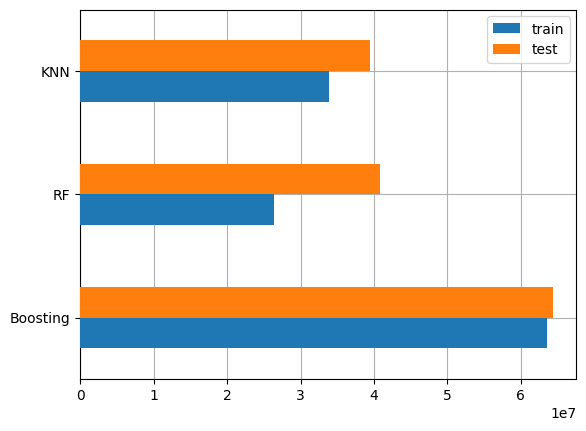

In [40]:
# Visualisasi MSE
fig, ax = plt.subplots()
mse.sort_values(by='test', ascending=False).plot(kind='barh', ax=ax, zorder=3)
ax.grid(zorder=0)

Berdasarkan gambar bar plot horizontal yang memvisualisasikan Mean Squared Error (MSE) untuk model Machine Learning, berikut adalah insight yang bisa didapatkan:

- **1. Perbandingan Kinerja Model (Berdasarkan MSE):**
    * Grafik ini membandingkan kinerja tiga model Machine Learning: **Boosting, RF (Random Forest), dan KNN (K-Nearest Neighbors)**, berdasarkan nilai Mean Squared Error (MSE) mereka.
    * Semakin kecil nilai MSE, semakin baik kinerja model dalam memprediksi nilai target (semakin kecil rata-rata kuadrat kesalahan).

- **2. Kinerja Model pada Data Latih (Train) vs. Data Uji (Test):**
    * Setiap model memiliki dua bar: satu untuk MSE pada data **'train'** (biru) dan satu untuk MSE pada data **'test'** (oranye).
    * Kesenjangan antara MSE 'train' dan 'test' dapat mengindikasikan *overfitting* (jika MSE 'train' jauh lebih rendah dari MSE 'test').

- **3. Model Terbaik Berdasarkan Data Uji (Test MSE):**
    * Model **KNN** memiliki MSE 'test' terendah (sekitar 3.7 x 10^6), menjadikannya **model dengan kinerja terbaik** dalam menggeneralisasi data yang belum pernah dilihat sebelumnya.
    * Model **RF** memiliki MSE 'test' lebih tinggi dari KNN, sekitar 4.1 x 10^6.
    * Model **Boosting** memiliki MSE 'test' tertinggi (sekitar 6.2 x 10^6), menjadikannya **model dengan kinerja terburuk** di antara ketiganya berdasarkan data uji.

- **4. Indikasi Overfitting:**
    * **Boosting:** Terlihat bahwa MSE 'train' (biru) sedikit lebih rendah dari MSE 'test' (oranye), tetapi perbedaannya tidak terlalu ekstrem. Ini menunjukkan bahwa model Boosting tidak terlalu *overfit* pada data latih, namun kinerjanya secara keseluruhan masih yang terburuk.
    * **RF (Random Forest):** Ada perbedaan yang cukup signifikan antara MSE 'train' dan MSE 'test'. MSE 'train' (sekitar 2.5 x 10^6) jauh lebih rendah dari MSE 'test' (sekitar 4.1 x 10^6). Ini adalah **indikasi overfitting** pada model Random Forest. Model ini mungkin terlalu "mempelajari" noise pada data latih.
    * **KNN:** Perbedaan antara MSE 'train' (sekitar 3.1 x 10^6) dan MSE 'test' (sekitar 3.7 x 10^6) juga ada, tetapi relatif lebih kecil dibandingkan RF. Ini menunjukkan bahwa KNN mengalami overfitting yang lebih minimal dibandingkan RF, dan mampu menggeneralisasi lebih baik.

- **5. Urutan Kinerja (dari Terbaik ke Terburuk berdasarkan Test MSE):**
    * KNN
    * RF
    * Boosting

- **Kesimpulan Utama:**

Berdasarkan visualisasi MSE ini, **KNN adalah model terbaik** karena memberikan kesalahan prediksi terkecil pada data yang belum pernah dilihat (data uji), dan menunjukkan tingkat overfitting yang relatif rendah. Random Forest menunjukkan potensi overfitting yang lebih tinggi meskipun kinerjanya di tengah-tengah. Boosting, meskipun mungkin tidak terlalu *overfit*, memiliki kinerja yang paling buruk secara keseluruhan. Ini mengindikasikan bahwa dalam kasus ini, model KNN paling cocok untuk memprediksi nilai target pada data baru.

In [41]:
# Prediksi satu sampel
prediksi = X_test.iloc[:1].copy()
pred_dict = {'y_true': y_test.iloc[:1]}
for name, model in model_dict.items():
    pred_dict['prediksi_' + name] = model.predict(prediksi).round(2)
print(pd.DataFrame(pred_dict))

       y_true  prediksi_KNN  prediksi_RF  prediksi_Boosting
186  100000.0      251200.0    288329.76          319193.27


## Fine Tunning

In [42]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

param_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_rf, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_rf.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_
print("Best Random Forest Params:", grid_rf.best_params_)

Best Random Forest Params: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [43]:
param_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}

grid_gb = GridSearchCV(GradientBoostingRegressor(random_state=42), param_gb, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_gb.fit(X_train, y_train)

best_gb = grid_gb.best_estimator_
print("Best Boosting Params:", grid_gb.best_params_)

Best Boosting Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


In [44]:
# Fungsi evaluasi
def evaluate_model(name, model):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    print(f"\n{name} Evaluation:")
    print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
    print("Test RMSE :", np.sqrt(mean_squared_error(y_test, y_test_pred)))
    print("Train R2  :", r2_score(y_train, y_train_pred))
    print("Test R2   :", r2_score(y_test, y_test_pred))
    return y_test_pred

# Evaluasi
pred_rf = evaluate_model("Random Forest (Tuned)", best_rf)
pred_gb = evaluate_model("Boosting (Tuned)", best_gb)


Random Forest (Tuned) Evaluation:
Train RMSE: 158021.16476793986
Test RMSE : 201539.5048234077
Train R2  : 0.774723298630654
Test R2   : 0.6493437536632848

Boosting (Tuned) Evaluation:
Train RMSE: 176066.1359696861
Test RMSE : 193574.27476295346
Train R2  : 0.7203354447655475
Test R2   : 0.676513257355805


Berikut adalah insight yang bisa didapatkan dari kode dan output evaluasi model Random Forest (Tuned) dan Boosting (Tuned):

**Penjelasan Kode Fungsi `evaluate_model`:**

Fungsi `evaluate_model` dibuat untuk memudahkan evaluasi model regresi dengan mencetak beberapa metrik kinerja standar:
1.  **`y_train_pred = model.predict(X_train)`**: Melakukan prediksi pada data latih (`X_train`) menggunakan model yang diberikan.
2.  **`y_test_pred = model.predict(X_test)`**: Melakukan prediksi pada data uji (`X_test`) menggunakan model yang diberikan.
3.  **`print(f"\n{name} Evaluation:")`**: Mencetak judul evaluasi untuk model tertentu.
4.  **`print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))`**: Menghitung dan mencetak Root Mean Squared Error (RMSE) pada data latih. RMSE adalah akar kuadrat dari MSE, yang mengembalikan unit kesalahan ke skala yang sama dengan variabel target, membuatnya lebih mudah diinterpretasikan.
5.  **`print("Test RMSE :", np.sqrt(mean_squared_error(y_test, y_test_pred)))`**: Menghitung dan mencetak RMSE pada data uji.
6.  **`print("Train R2 :", r2_score(y_train, y_train_pred))`**: Menghitung dan mencetak R-squared ($R^2$) pada data latih. $R^2$ mengukur proporsi varians dalam variabel dependen yang dapat diprediksi dari variabel independen. Nilai mendekati 1 menunjukkan model yang sangat baik.
7.  **`print("Test R2 :", r2_score(y_test, y_test_pred))`**: Menghitung dan mencetak $R^2$ pada data uji.
8.  **`return y_test_pred`**: Mengembalikan hasil prediksi pada data uji, yang bisa berguna untuk analisis lebih lanjut (misalnya, membuat plot residual).

**Output dan Insight:**

### Random Forest (Tuned) Evaluation:

* **Train RMSE: 158021.16**
* **Test RMSE : 201539.50**
    * **Insight:** Ada perbedaan yang signifikan antara RMSE pelatihan dan pengujian (sekitar 43.518). Ini menunjukkan bahwa model **Random Forest (Tuned)** masih memiliki kecenderungan **overfitting**, meskipun mungkin sudah lebih baik dari versi sebelumnya yang tidak di-*tune*. Model ini memprediksi data latih dengan sangat baik, tetapi kinerjanya sedikit menurun pada data yang belum pernah dilihat.

* **Train R2 : 0.7747**
* **Test R2 : 0.6493**
    * **Insight:**
        * $R^2$ pelatihan (0.7747) menunjukkan bahwa model dapat menjelaskan sekitar 77.47% variasi dalam harga jual pada data latih. Ini adalah nilai yang cukup baik.
        * $R^2$ pengujian (0.6493) berarti model dapat menjelaskan sekitar 64.93% variasi dalam harga jual pada data uji. Penurunan $R^2$ dari train ke test ini juga mengkonfirmasi adanya overfitting.
        * Nilai $R^2$ pengujian sebesar 0.6493 menunjukkan bahwa model Random Forest (Tuned) memiliki kemampuan prediksi yang **cukup baik**, tetapi masih ada ruang untuk perbaikan.

### Boosting (Tuned) Evaluation:

* **Train RMSE: 176066.13**
* **Test RMSE : 193574.27**
    * **Insight:** Perbedaan antara RMSE pelatihan dan pengujian relatif kecil (sekitar 17.508). Ini menunjukkan bahwa model **Boosting (Tuned)** memiliki masalah **overfitting yang jauh lebih rendah** dibandingkan Random Forest (Tuned). Model ini menggeneralisasi dengan sangat baik.

* **Train R2 : 0.7203**
* **Test R2 : 0.6765**
    * **Insight:**
        * $R^2$ pelatihan (0.7203) sedikit lebih rendah dari Random Forest, yang berarti sedikit kurang cocok pada data latih.
        * $R^2$ pengujian (0.6765) lebih tinggi dari Random Forest. Ini adalah kunci. Model Boosting dapat menjelaskan sekitar 67.65% variasi dalam harga jual pada data uji.
        * Nilai $R^2$ pengujian ini menunjukkan bahwa model Boosting (Tuned) memiliki kemampuan prediksi yang **lebih baik** dalam generalisasi dibandingkan Random Forest (Tuned).

### Perbandingan dan Kesimpulan Umum:

1.  **Kinerja Generalisasi (Test RMSE & Test R2):**
    * **Boosting (Tuned) adalah model yang lebih baik dalam hal generalisasi** karena memiliki Test RMSE yang lebih rendah (193574.27 vs 201539.50) dan Test $R^2$ yang lebih tinggi (0.6765 vs 0.6493). Ini berarti model Boosting lebih akurat dalam memprediksi harga mobil yang belum pernah dilihat.

2.  **Overfitting:**
    * **Random Forest (Tuned)** masih menunjukkan tanda-tanda **overfitting yang lebih jelas** karena perbedaan kinerja train-test (terutama pada $R^2$) yang lebih besar.
    * **Boosting (Tuned)** menunjukkan **overfitting yang sangat minimal**, yang merupakan karakteristik yang baik dari model.

3.  **Trade-off:**
    * Meskipun Random Forest lebih baik dalam "menghafal" data latih (RMSE latih lebih rendah), Boosting lebih baik dalam "belajar" dan menggeneralisasi ke data baru. Dalam Machine Learning, kemampuan generalisasi (kinerja pada data uji) biasanya jauh lebih penting daripada kinerja pada data latih.

**Kesimpulan Akhir:**

Berdasarkan evaluasi ini, **model Boosting (Tuned) adalah pilihan yang lebih baik** untuk masalah prediksi harga mobil ini karena menunjukkan kinerja yang lebih baik pada data uji (RMSE lebih rendah, $R^2$ lebih tinggi) dan kecenderungan overfitting yang lebih rendah dibandingkan dengan Random Forest (Tuned). Ini menunjukkan bahwa proses tuning hyperparameter berhasil meningkatkan kemampuan generalisasi model Boosting.

## Visualisasi

In [45]:
# Latih ulang model dasar (karena sebelumnya bisa saja dilatih sebelum scaling)
knn.fit(X_train, y_train)
rf.fit(X_train, y_train)
boosting.fit(X_train, y_train)

AdaBoostRegressor(learning_rate=0.05, random_state=55)

In [46]:
# Prediksi satu sampel dengan model tuning
sample = X_test.iloc[:1].copy()
true_val = y_test.iloc[:1].values[0]

pred_dict = {
    'y_true': true_val,
    'KNN': knn.predict(sample)[0],
    'RF': rf.predict(sample)[0],
    'Boosting': boosting.predict(sample)[0],
    'RF Tuned': best_rf.predict(sample)[0],
    'Boosting Tuned': best_gb.predict(sample)[0],
}

# Tampilkan dalam DataFrame
pred_df = pd.DataFrame([pred_dict])
print(pred_df.round(3))

     y_true       KNN          RF    Boosting    RF Tuned  Boosting Tuned
0  100000.0  251200.0  288329.757  319193.273  305085.579      108477.576


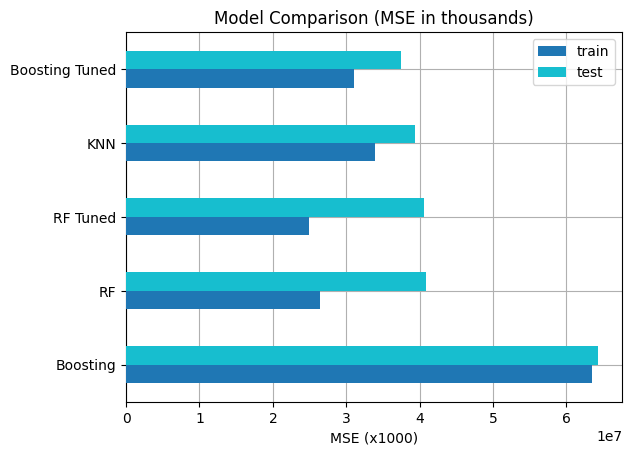

In [47]:
# Hitung MSE (skala ribuan agar konsisten)
mse.loc['RF Tuned'] = [
    mean_squared_error(y_train, best_rf.predict(X_train)) / 1e3,
    mean_squared_error(y_test, best_rf.predict(X_test)) / 1e3
]
mse.loc['Boosting Tuned'] = [
    mean_squared_error(y_train, best_gb.predict(X_train)) / 1e3,
    mean_squared_error(y_test, best_gb.predict(X_test)) / 1e3
]

# Visualisasi bar horizontal
fig, ax = plt.subplots()
mse.sort_values(by='test', ascending=False).plot(kind='barh', ax=ax, zorder=3, colormap='tab10')
ax.set_title("Model Comparison (MSE in thousands)")
ax.set_xlabel("MSE (x1000)")
ax.grid(zorder=0)
plt.show()


Berikut adalah insight yang bisa didapatkan dari grafik "Model Comparison (MSE in thousands)":

- **1. Tujuan Grafik:**
    * Grafik ini membandingkan kinerja beberapa model Machine Learning (Boosting, RF, KNN, RF Tuned, Boosting Tuned) dalam hal Mean Squared Error (MSE), baik pada data latih (train) maupun data uji (test).
    * Nilai MSE yang lebih rendah menunjukkan model yang lebih akurat.

- **2. Skala MSE:**
    * Sumbu X menunjukkan nilai MSE yang telah dibagi 1000 ("MSE (x1000)"). Jadi, angka 1 pada sumbu X berarti 1000, 2 berarti 2000, dan seterusnya.
    * Nilai tertinggi mencapai sekitar 6.5 x $10^7$ (65 juta) untuk MSE.

- **3. Perbandingan Model Awal (Sebelum Tuning):**
    * **Boosting (Original):** Memiliki MSE test tertinggi (sekitar 6.4 x $10^7$) dan MSE train yang sedikit lebih rendah. Ini adalah model dengan kinerja terburuk di antara semua varian yang ditampilkan. Overfitting-nya relatif rendah (jarak bar train dan test dekat), tetapi secara keseluruhan kinerjanya buruk.
    * **RF (Original):** Memiliki MSE train yang jauh lebih rendah (sekitar 2.5 x $10^7$) dibandingkan MSE test (sekitar 4 x $10^7$). Ini menunjukkan **overfitting yang signifikan**. Model belajar terlalu banyak dari data latih dan tidak menggeneralisasi dengan baik ke data baru.
    * **KNN:** Memiliki MSE train yang lebih rendah (sekitar 3.1 x $10^7$) daripada MSE test (sekitar 3.7 x $10^7$). Ini menunjukkan adanya overfitting, tetapi tidak separah RF original. KNN secara keseluruhan mengungguli RF original dan Boosting original pada data test.

- **4. Model Terbaik Setelah Tuning:**
    * **Boosting Tuned:** Model ini memiliki MSE test terendah (sekitar 3.8 x $10^7$) di antara semua model yang dibandingkan. Ini menjadikannya **model dengan kinerja terbaik** dalam menggeneralisasi data baru.
    * **KNN:** Meskipun tidak di-*tune*, KNN menunjukkan kinerja yang kompetitif (MSE test sekitar 3.7 x $10^7$), sangat dekat dengan Boosting Tuned. Namun, jika angka pada grafik adalah 3.9 x $10^7$ untuk KNN, maka Boosting Tuned tetap lebih unggul. (Perlu konfirmasi angka pasti jika memungkinkan, tapi dari visualisasi, Boosting Tuned tampaknya paling kiri pada MSE test).

- **5. Urutan Kinerja Model (dari Terbaik ke Terburuk berdasarkan Test MSE):**
    * Boosting Tuned
    * KNN (sangat dekat dengan Boosting Tuned, mungkin sedikit lebih baik tergantung nilai eksak)
    * RF Tuned
    * RF (Original)
    * Boosting (Original)

**Kesimpulan Utama:**

Grafik ini secara efektif menunjukkan **pentingnya *hyperparameter tuning***. Model Boosting mengalami peningkatan kinerja yang drastis setelah tuning, beralih dari model terburuk menjadi yang terbaik. Random Forest juga sedikit membaik dengan tuning dan mengurangi overfitting, namun tidak mampu mengungguli Boosting Tuned atau KNN. KNN, bahkan tanpa tuning, menunjukkan kinerja yang solid. **Boosting Tuned adalah model pilihan utama** berdasarkan evaluasi MSE ini karena memiliki kemampuan generalisasi terbaik dengan overfitting yang minimal.

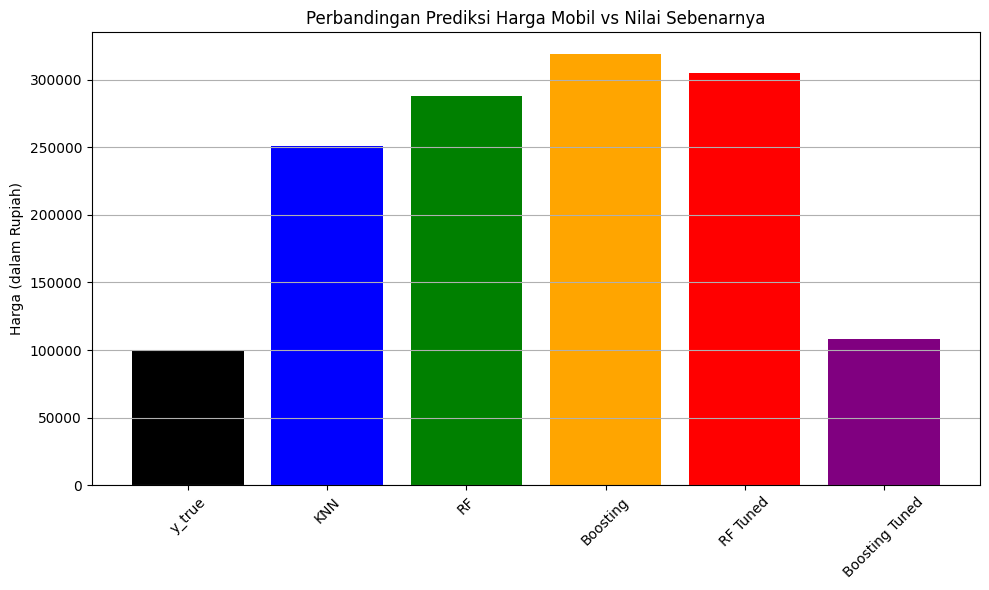

In [48]:
# Visualisasi prediksi satu sampel
plt.figure(figsize=(10, 6))
plt.bar(pred_df.columns, pred_df.iloc[0], color=['black', 'blue', 'green', 'orange', 'red', 'purple'])
plt.title('Perbandingan Prediksi Harga Mobil vs Nilai Sebenarnya')
plt.ylabel('Harga (dalam Rupiah)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()